In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
dinner_audio = pd.read_csv('./csv/dinner_audio.csv')
party_audio = pd.read_csv('./csv/party_audio.csv')
sleep_audio = pd.read_csv('./csv/sleep_audio.csv')
workout_audio = pd.read_csv('./csv/workout_audio.csv')

In [3]:
dinner_track = pd.read_csv('./csv/dinner_track.csv')
party_track = pd.read_csv('./csv/party_track.csv')
sleep_track = pd.read_csv('./csv/sleep_track.csv')
workout_track = pd.read_csv('./csv/workout_track.csv')

In [4]:
dinner_audio.dtypes

id         int64
name      object
mfcc     float64
scem     float64
scom     float64
srom     float64
sbwm     float64
tempo    float64
rmse     float64
dtype: object

In [5]:
dinner_audio['playlist'] = 'dinner'
party_audio['playlist'] = 'party'
sleep_audio['playlist'] = 'sleep'
workout_audio['playlist'] = 'workout'

In [6]:
frames = [dinner_audio, party_audio, sleep_audio, workout_audio]

result = pd.concat(frames)
result.drop(['id', 'name'], axis=1, inplace=True)
result.head()

,mfcc,scem,scom,srom,sbwm,tempo,rmse,playlist
0,2.182090,2008.227306,22.166286,4271.332505,2362.906658,129.199219,4.348369,dinner
1,-0.420979,1810.502120,22.819678,3800.143688,2217.648805,89.102909,3.749902,dinner
2,0.431973,1920.574739,20.068933,4231.882744,2553.858556,95.703125,4.450774,dinner
3,5.984499,1777.566251,21.454589,3898.109762,2247.092578,161.499023,6.248868,dinner
4,1.475227,2629.842184,21.647935,5873.931148,2734.929565,89.102909,3.963258,dinner


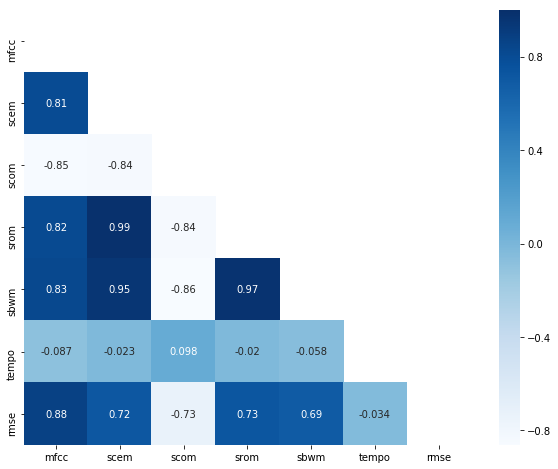

In [7]:
import seaborn as sns

mask = np.zeros_like(result.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(result.corr(), mask=mask, annot=True, cmap="Blues")

In [8]:
result.isna().sum()

mfcc        0
scem        0
scom        0
srom        0
sbwm        0
tempo       0
rmse        0
playlist    0
dtype: int64

workout    49
dinner     44
sleep      44
party      37
Name: playlist, dtype: int64

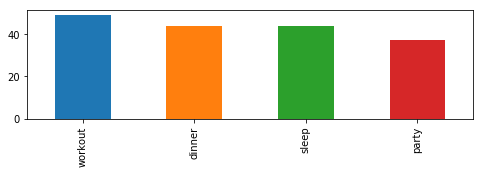

In [9]:
fig, ax = plt.subplots(figsize=(8,2))
ax = result.playlist.value_counts().plot.bar()

result.playlist.value_counts()

In [10]:
y = pd.get_dummies(data=result.playlist)
X = result.loc[:, result.columns != 'playlist']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

In [11]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.51428571 0.2        0.65714286 0.77142857 0.23529412]
Accuracy: 0.48 (+/- 0.45)


In [12]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7777777777777778

In [13]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.7777777777777778

In [14]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.7991071428571428

In [15]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['workout', 'sleep', 'dinner', 'party']
precision_recall.index.name = 'playlist'
precision_recall

,precision,recall,f1_score
playlist,,,
workout,1.000000,1.000000,1.000000
sleep,0.625000,0.625000,0.625000
dinner,1.000000,1.000000,1.000000
party,0.571429,0.571429,0.571429


Confusion matrix, without normalization
[[4 0 0 0]
 [0 5 0 3]
 [0 0 8 0]
 [0 3 0 4]]


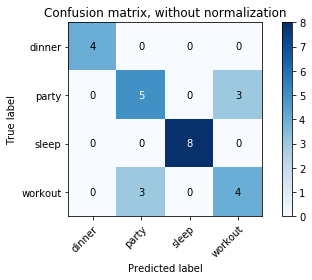

In [16]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [17]:
y = label_binarize(y, classes=['workout', 'sleep', 'dinner', 'party'])
n_classes = y.shape[1]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [19]:
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=40))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [20]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [21]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [22]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [23]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [24]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

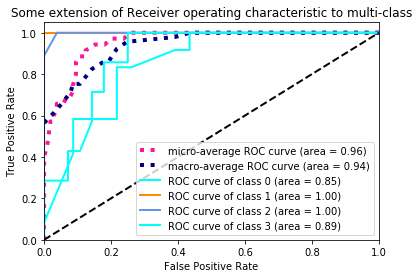

In [25]:
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()